# Makemore - MLP
Proper Training and Hyperparameter Tuning --- remaining ~30% of the video

In [11]:
import string
import torch
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open('../names.txt') as f:
    names = f.read().splitlines()

In [3]:
len(names)

32033

# Dataset

In [5]:
vocab = ['.'] + list(string.ascii_lowercase)
s_i = {s:i for i,s in enumerate(vocab)}
i_s = {i:s for s,i in s_i.items()}
print(s_i,'\n')
print(i_s)

{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26} 

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [9]:
def build_dataset(names, block_size=3):
    X, Y = [], []
    for w in names:
        context = [0] * block_size
        for ch in w + '.':
            ix = s_i[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append, like a rolling window

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

## Train-Val-Test Split

as the capacity of neural network grows so does its ability to overfit. Sampling without split, we'll get examples that already exist in the names list.

train: 0.8, val: 0.1, test: 0.1

In [10]:
X, Y = build_dataset(names)

torch.Size([228146, 3]) torch.Size([228146])


In [17]:
X_train, X_val, Y_train, Y_val = train_test_split(X,Y,test_size=0.2,random_state=42,shuffle=True,stratify=Y)
X_val, X_test, Y_val, Y_test = train_test_split(X_val,Y_val, test_size=0.5,random_state=52,shuffle=True,stratify=Y_val)

In [18]:
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

(torch.Size([182516, 3]),
 torch.Size([182516]),
 torch.Size([22815, 3]),
 torch.Size([22815]),
 torch.Size([22815, 3]),
 torch.Size([22815]))

## Hyperparameters

In [36]:
seed = 2147483647
hidden_dim = 100
lr = 0.1
epochs = 30000
batch_size = 32

## Training on Train Set with LR Decay

In [37]:
g = torch.Generator().manual_seed(seed)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,hidden_dim), generator=g)
b1 = torch.randn(hidden_dim, generator=g)
W2 = torch.randn((hidden_dim,27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C,W1,b1,W2,b2]
for p in parameters:
    p.requires_grad=True
    
# ------------
losses = []

for epoch in range(1,epochs+1):
    
    # mini-batch creation
    ix = torch.randint(0,X_train.shape[0], (batch_size,))
    
    # forward pass
    
    emb = C[X_train[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    
    loss = F.cross_entropy(logits, Y_train[ix])
    losses.append(loss.item())
    
    for p in parameters:
        p.grad = None
        
    # calc gradients
    loss.backward()
    
    # lr decay
    if epoch > 20000:
        lr = 0.01
    elif epoch > 28000:
        lr = 0.001
    
    # optimize
    for p in parameters:
        p.data += -lr * p.grad
        
    if epoch%1000 == 0:
        print(f"loss at epoch {epoch}:\t {loss.item()}")
        
# --- Train loss
emb = C[X_train]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_train)
print("\nTrain Loss:",loss.item())

loss at epoch 1000:	 2.8687257766723633
loss at epoch 2000:	 2.6967010498046875
loss at epoch 3000:	 2.8290207386016846
loss at epoch 4000:	 1.9281483888626099
loss at epoch 5000:	 2.6173160076141357
loss at epoch 6000:	 2.553903341293335
loss at epoch 7000:	 2.3292837142944336
loss at epoch 8000:	 2.0534415245056152
loss at epoch 9000:	 2.6235527992248535
loss at epoch 10000:	 2.0897772312164307
loss at epoch 11000:	 2.2180423736572266
loss at epoch 12000:	 2.501567840576172
loss at epoch 13000:	 2.5771288871765137
loss at epoch 14000:	 2.291813611984253
loss at epoch 15000:	 2.534663200378418
loss at epoch 16000:	 2.402402877807617
loss at epoch 17000:	 2.1816565990448
loss at epoch 18000:	 2.2233901023864746
loss at epoch 19000:	 2.4463062286376953
loss at epoch 20000:	 2.085585832595825
loss at epoch 21000:	 2.4331088066101074
loss at epoch 22000:	 2.275172710418701
loss at epoch 23000:	 2.391052722930908
loss at epoch 24000:	 1.890748143196106
loss at epoch 25000:	 2.6059048175811

### Validation Loss

train loss ~= val loss --- so not overfitting

In [38]:
# --- Validation loss
emb = C[X_val]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_val)
print("\nValidation Loss:",loss.item())


Validation Loss: 2.3646342754364014


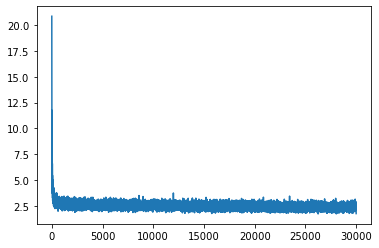

In [40]:
plt.plot(losses)

___

**Let's try different set of hyperparameters**

In [78]:
seed = 2147483647
hidden_dim = 512
lr = 0.1
epochs = 60000
batch_size = 64

In [79]:
g = torch.Generator().manual_seed(seed)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,hidden_dim), generator=g)
b1 = torch.randn(hidden_dim, generator=g)
W2 = torch.randn((hidden_dim,27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C,W1,b1,W2,b2]
for p in parameters:
    p.requires_grad=True
    
# ------------
losses = []

for epoch in range(1,epochs+1):
    
    # mini-batch creation
    ix = torch.randint(0,X_train.shape[0], (batch_size,))
    
    # forward pass
    
    emb = C[X_train[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)
    logits = h @ W2 + b2
    
    loss = F.cross_entropy(logits, Y_train[ix])
    losses.append(loss.item())
    
    for p in parameters:
        p.grad = None
        
    # calc gradients
    loss.backward()
    
    # lr decay
    if epoch > 45000:
        lr = 0.01
    elif epoch > 58000:
        lr = 0.001
    
    # optimize
    for p in parameters:
        p.data += -lr * p.grad
        
    if epoch%3000 == 0:
        print(f"loss at epoch {epoch}:\t {loss.item()}")
        
# --- Train loss
emb = C[X_train]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_train)
print("\nTrain Loss:",loss.item())

loss at epoch 3000:	 3.1720545291900635
loss at epoch 6000:	 3.154723882675171
loss at epoch 9000:	 2.816204786300659
loss at epoch 12000:	 2.308276653289795
loss at epoch 15000:	 2.7432219982147217
loss at epoch 18000:	 2.313694715499878
loss at epoch 21000:	 2.6692440509796143
loss at epoch 24000:	 2.4976541996002197
loss at epoch 27000:	 2.896728515625
loss at epoch 30000:	 2.445673942565918
loss at epoch 33000:	 2.3393900394439697
loss at epoch 36000:	 2.427089214324951
loss at epoch 39000:	 2.507333278656006
loss at epoch 42000:	 2.2799088954925537
loss at epoch 45000:	 2.228731632232666
loss at epoch 48000:	 2.6496269702911377
loss at epoch 51000:	 2.1162164211273193
loss at epoch 54000:	 2.33583927154541
loss at epoch 57000:	 2.1414384841918945
loss at epoch 60000:	 2.239851713180542

Train Loss: 2.24766206741333


In [80]:
# --- Validation loss
emb = C[X_val]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_val)
print("\nValidation Loss:",loss.item())

# --- Test loss
emb = C[X_test]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_test)
print("\nTest Loss:",loss.item())


Validation Loss: 2.262108325958252

Test Loss: 2.257904052734375


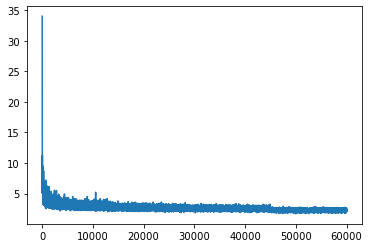

In [81]:
plt.plot(losses)

## Visualizing the Embedding Space

look how a,e,i,o,u are so near, so cute :')

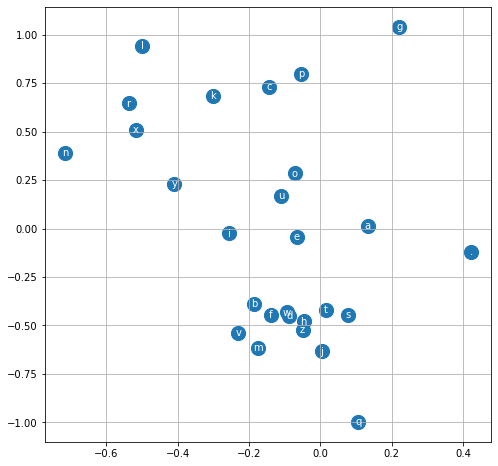

In [82]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(),C[i,1].item(),i_s[i], ha='center', va='center', color='white')
plt.grid('minor')

**Let's try changing the embedding size**

In [91]:
seed = 2147483647
hidden_dim = 200
lr = 0.1
epochs = 100000
batch_size = 32

In [92]:
g = torch.Generator().manual_seed(seed)
C = torch.randn((27,5), generator=g)
W1 = torch.randn((3*5,hidden_dim), generator=g)
b1 = torch.randn(hidden_dim, generator=g)
W2 = torch.randn((hidden_dim,27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C,W1,b1,W2,b2]
for p in parameters:
    p.requires_grad=True
    
# ------------
log_losses = []

for epoch in range(1,epochs+1):
    
    # mini-batch creation
    ix = torch.randint(0,X_train.shape[0], (batch_size,))
    
    # forward pass
    
    emb = C[X_train[ix]]
    h = torch.tanh(emb.view(-1,3*5) @ W1 + b1)
    logits = h @ W2 + b2
    
    loss = F.cross_entropy(logits, Y_train[ix])
    log_losses.append(loss.log10().item())
    
    for p in parameters:
        p.grad = None
        
    # calc gradients
    loss.backward()
    
    if epoch > 50000:
        lr = 0.01
    
    # optimize
    for p in parameters:
        p.data += -lr * p.grad
        
    if epoch%(epochs//10) == 0:
        print(f"loss at epoch {epoch}:\t {loss.item()}")
        
# --- Train loss
emb = C[X_train]
h = torch.tanh(emb.view(-1,3*5) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_train)
print("\nTrain Loss:",loss.item())

loss at epoch 10000:	 3.249988555908203
loss at epoch 20000:	 2.410412549972534
loss at epoch 30000:	 2.908151149749756
loss at epoch 40000:	 2.775571584701538
loss at epoch 50000:	 2.641909599304199
loss at epoch 60000:	 2.2548651695251465
loss at epoch 70000:	 2.461887836456299
loss at epoch 80000:	 2.193615436553955
loss at epoch 90000:	 2.4230637550354004
loss at epoch 100000:	 1.8943843841552734

Train Loss: 2.227808713912964


In [93]:
# --- Validation loss
emb = C[X_val]
h = torch.tanh(emb.view(-1,3*5) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_val)
print("\nValidation Loss:",loss.item())

# --- Test loss
emb = C[X_test]
h = torch.tanh(emb.view(-1,3*5) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_test)
print("\nTest Loss:",loss.item())


Validation Loss: 2.2535226345062256

Test Loss: 2.2433764934539795


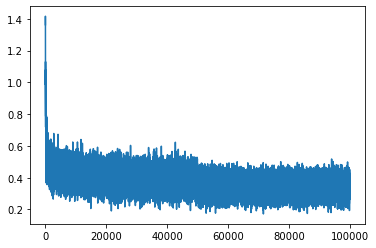

In [94]:
plt.plot(log_losses)

## A Complete New Set of Hyperparameters

In [159]:
seed = 42
hidden_dim = 512
lr = 0.1
epochs = 100000
batch_size = 64
emb_dim = 5
block_size = 4

In [160]:
def build_dataset(names, block_size=3):
    X, Y = [], []
    for w in names:
        context = [0] * block_size
        for ch in w + '.':
            ix = s_i[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append, like a rolling window

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

X,Y = build_dataset(names, block_size=block_size)

torch.Size([228146, 4]) torch.Size([228146])


In [161]:
X_train, X_val, Y_train, Y_val = train_test_split(X,Y,test_size=0.2,random_state=42,shuffle=True,stratify=Y)
X_val, X_test, Y_val, Y_test = train_test_split(X_val,Y_val, test_size=0.5,random_state=52,shuffle=True,stratify=Y_val)

In [162]:
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

(torch.Size([182516, 4]),
 torch.Size([182516]),
 torch.Size([22815, 4]),
 torch.Size([22815]),
 torch.Size([22815, 4]),
 torch.Size([22815]))

In [163]:
g = torch.Generator().manual_seed(seed)
C = torch.randn((27,emb_dim), generator=g)
W1 = torch.randn((block_size*emb_dim,hidden_dim), generator=g)
b1 = torch.randn(hidden_dim, generator=g)
W2 = torch.randn((hidden_dim,27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C,W1,b1,W2,b2]
for p in parameters:
    p.requires_grad=True
    
# ------------
log_train_losses = []
log_val_losses = []

for epoch in range(1,epochs+1):
    
    # mini-batch creation
    ix = torch.randint(0,X_train.shape[0], (batch_size,))
    
    # forward pass
    
    emb = C[X_train[ix]]
    h = torch.tanh(emb.view(-1,block_size*emb_dim) @ W1 + b1)
    logits = h @ W2 + b2
    
    loss = F.cross_entropy(logits, Y_train[ix])
    log_train_losses.append(loss.log10().item())
    
    for p in parameters:
        p.grad = None
        
    # calc gradients
    loss.backward()
    
    if epoch > 60000:
        lr = 0.01
    elif epoch > 90000:
        lr = 0.001
    
    # optimize
    for p in parameters:
        p.data += -lr * p.grad
        
    if epoch%(epochs//10) == 0:
        print(f"train loss at epoch {epoch}:\t {loss.item()}")
        
    if epoch%(epochs//5) == 0:
        with torch.no_grad():
            print('-'*30)
            emb = C[X_val]
            h = torch.tanh(emb.view(-1,block_size*emb_dim) @ W1 + b1)
            logits = h @ W2 + b2
            loss = F.cross_entropy(logits, Y_val)
            print(f"val loss at epoch {epoch}:\t {loss.item()}\n{'-'*30}")
            log_val_losses.append(loss.log10().item())
            
        
        
# --- Train loss
emb = C[X_train]
h = torch.tanh(emb.view(-1,block_size*emb_dim) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_train)
print("\nTrain Loss:",loss.item())

train loss at epoch 10000:	 2.8756866455078125
train loss at epoch 20000:	 2.8677737712860107
------------------------------
val loss at epoch 20000:	 2.6698057651519775
------------------------------
train loss at epoch 30000:	 3.0521044731140137
train loss at epoch 40000:	 2.462635040283203
------------------------------
val loss at epoch 40000:	 2.638075351715088
------------------------------
train loss at epoch 50000:	 2.5693414211273193
train loss at epoch 60000:	 2.340513229370117
------------------------------
val loss at epoch 60000:	 2.4111552238464355
------------------------------
train loss at epoch 70000:	 2.303117275238037
train loss at epoch 80000:	 2.224220037460327
------------------------------
val loss at epoch 80000:	 2.1918106079101562
------------------------------
train loss at epoch 90000:	 2.22503399848938
train loss at epoch 100000:	 2.1953420639038086
------------------------------
val loss at epoch 100000:	 2.1897482872009277
------------------------------


In [164]:
# --- Test loss
emb = C[X_test]
h = torch.tanh(emb.view(-1,block_size*emb_dim) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_test)
print("\nTest Loss:",loss.item())


Test Loss: 2.179365396499634


**this improves on Andrej's Loss of around 2.18**

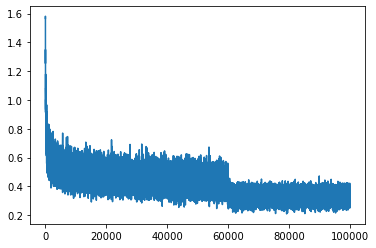

In [165]:
plt.plot(log_train_losses)

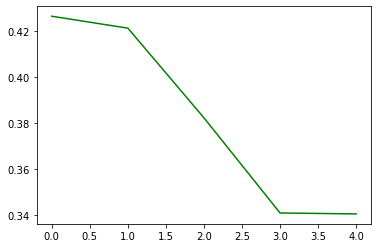

In [166]:
plt.plot(log_val_losses, color='green')

___

## Sampling!

In [167]:
g = torch.Generator().manual_seed(42)

for _ in range(25):
    
    name = ''
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits,dim=1)
        ix = torch.multinomial(probs, num_samples=1,generator=g).item()
        context = context[1:] + [ix]
        name += i_s[ix]
        if ix == 0:
            break
            
    print(name)

anukeen.
tis.
marian.
danmella.
silai.
darossan.
luvan.
epiace.
denneszi.
kerce.
joreigh.
dela.
mikhlyn.
adhvisin.
achallvi.
karcel.
jayma.
jach.
selari.
davon.
artur.
nacra.
reylynn.
mika.
jirah.


as you can see, much better than our bigrams model :) 

## All credits to Andrej Karpathy for this! He's amazing :)